# Cusp Analysis

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import pandas as pd
import sidetable
import utils
import StressTools as tools

## Clean up cusp data file

In [12]:
raw = pd.read_csv('cuspData/CuspDataFromKyleMohr.csv')

# Remove extra measurements beyond 2
raw = raw.groupby('Cusp_ID').head(2)

# Remove items that only have 1 angle measurement
freq = raw.stb.freq(['Cusp_ID'])
singles = freq.loc[freq['Count'] < 2]
mask = ~raw.Cusp_ID.isin(singles.Cusp_ID)
cusps = raw[mask].copy()

### Convert latitudes and longitudes

In [13]:
cusps['lon'] = (360 - cusps['Long_dd']) % 360
cusps['lat'] = 90 - cusps['Lat_dd']

## Split data into left and right groups

In [14]:
left_cusps = cusps.iloc[::2]
right_cusps = cusps.iloc[1::2]

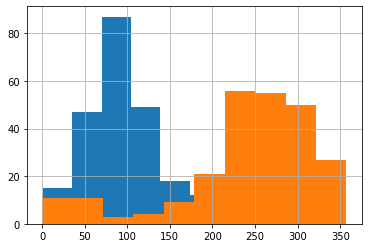

In [15]:
left_cusps.CompassA.hist()
right_cusps.CompassA.hist()

## Get stress field for cusps

In [16]:
interior = interior = utils.import_interior('interior1')

left_coords = left_cusps[['lat', 'lon']]
right_coords = right_cusps[['lat', 'lon']]

left_stress = tools.get_simon_stress_field(interior, left_coords, 0, 0.01, 0, 0)
right_stress = tools.get_simon_stress_field(interior, right_coords, 0, 0.01, 0, 0)

## Match Angles to stresses

In [38]:
from io import BytesIO
import base64

def figureToInlineImage(figure):
    file = BytesIO()
    figure.savefig(file, format='png')
    file.seek(0)
    
    png_data = base64.b64encode(file.getvalue()).decode()
    image_str = f'<img width="200" height="100" src="data:image/png;base64,{png_data}" />'
    
    return image_str

def match_angles(points, stresses, name, show_plots=True):
    results = []
    
    for point in points.itertuples():
        stress_data = stresses.loc[(stresses.lon == point.lon) & (stresses.lat == point.lat)]
        
        sorted_stress = stress_data.copy().sort_values('heading')
        angle = point.CompassA if point.CompassA >= 180 else (180 + point.CompassA) % 360

        spline = InterpolatedUnivariateSpline(sorted_stress.heading, sorted_stress.stress)
        slopes = spline.derivative()
        
        matched_stress = spline(angle)
        slope = slopes(angle)
        is_increasing = slope > 0
        max_stress = stress_data.stress.max()
        min_stress = stress_data.stress.min()
        
        sample_points = np.linspace(180, 360, 720)
        slope_list = slopes(sample_points)
        max_slope = slope_list.max()
        min_slope = slope_list.min()
        positive_slopes = slope_list[slope_list > 0]
        median_slope = np.median(positive_slopes)
        slope_ratio = slope / max_slope
        median_ratio = slope / median_slope

        image = ''
        if show_plots:
            fig, ax = plt.subplots(figsize=(4,2))
            
            ax.title.set_text(f'{name} - lat: {point.lat}, lon: {point.lon}')
            ax.vlines(angle, ymin=min_stress, ymax=max_stress, colors=['red'], linestyles='dashed')
            ax.hlines(matched_stress, xmin=175, xmax=360, colors=['red'], linestyles='dashed')

            spx = np.linspace(180, 360, 360)
            ax.plot(spx, spline(spx))
            image = figureToInlineImage(fig)
            plt.show()

        
        results.append(dict(lat=point.lat,
                            lon=point.lon,
                            Id=point.Id,
                            cycloid_number=point.Cycloid_Nu,
                            cusp_id=point.Cusp_ID,
                            orientation_original=point.CompassA,
                            orientation_translated=angle,
                            stress=matched_stress, 
                            max_stress=max_stress, 
                            slope=slope,
                            is_increasing=is_increasing,
                            max_slope=max_slope,
                            min_slope=min_slope,
                            median_positive_slope=median_slope,
                            slope_to_max=slope_ratio,
                            slope_to_median_positive=median_ratio,
                            stress_plot=image))
        
    return pd.DataFrame(results)

In [39]:
left_points = left_cusps #.loc[left_cusps.Cycloid_Nu == 13]
right_points = right_cusps #.loc[right_cusps.Cycloid_Nu == 13]


left_matched = match_angles(left_points, left_stress, 'Left Side', show_plots=False)
right_matched = match_angles(right_points, right_stress, 'Right Side', show_plots=False)
left_matched['cusp_direction'] = 'left'
right_matched['cusp_direction'] = 'right'

## Output Unified Dataset

In [40]:
all_matches = pd.concat([left_matched, right_matched])
all_matches.to_csv('./output/leftRight/interpolatedStress.csv.gz', compression='gzip', index=False)

In [41]:
all_matches

,lat,lon,Id,cycloid_number,cusp_id,orientation_original,orientation_translated,stress,max_stress,slope,is_increasing,max_slope,min_slope,median_positive_slope,slope_to_max,slope_to_median_positive,stress_plot,cusp_direction
0,44.614,351.386,1,1,1,113.869807,293.869807,44.00177366565439,61.641996,0.05850856688028947,True,2.052035,-1.602367,0.479497,0.028512,0.122021,,left
1,44.572,351.301,2,1,2,62.732584,242.732584,61.12270302155216,61.738495,-0.37338321514727413,False,2.059244,-1.605157,0.483152,-0.181320,-0.772807,,left
2,48.350,354.153,1,2,4,127.002526,307.002526,46.351202505515104,58.683520,0.3400984940789135,True,1.547409,-1.248322,0.362965,0.219786,0.937001,,left
3,54.980,349.844,1,3,6,147.763213,327.763213,47.00157946121903,64.734176,-0.2444210212166907,False,1.039175,-1.089466,0.478691,-0.235207,-0.510603,,left
4,41.352,333.050,1,4,7,138.447387,318.447387,37.56179177273483,81.574143,-0.4300958719509636,False,2.713366,-1.473370,1.019107,-0.158510,-0.422032,,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,19.967,229.342,2,86,248,65.772255,245.772255,70.91206534990272,105.820195,0.941123515282063,True,4.520551,-6.730490,0.924033,0.208188,1.018496,,right
243,21.478,230.068,3,86,249,33.996459,213.996459,49.343999336125556,105.226639,0.5972539908705512,True,3.977077,-6.077582,0.957187,0.150174,0.623968,,right
244,26.633,231.136,4,86,250,19.573126,199.573126,31.19012619897229,103.009563,1.2975256315197383,True,2.669185,-4.501652,1.023198,0.486113,1.268108,,right
245,55.797,281.789,1,87,251,355.333142,355.333142,14.381329321425909,89.959809,0.05351218302018565,True,1.268347,-1.628403,0.763580,0.042191,0.070081,,right


In [ ]:
# left_points = left_cusps.loc[left_cusps.Cycloid_Nu == 13]
right_points = right_cusps #.loc[right_cusps.Cycloid_Nu == 14]


# left_matched = match_angles(left_points, left_stress, 'Left Side', show_plots=True)
right_matched = match_angles(right_points, right_stress, 'Right Side', show_plots=True)
# left_matched['cusp_direction'] = 'left'
# right_matched['cusp_direction'] = 'right'

In [ ]:
from IPython.display import HTML

pd.set_option('display.max_colwidth', None)


HTML(right_matched[['cycloid_number', 'Id', 'stress', 'max_stress', 'orientation_original', 'orientation_translated', 'stress_plot']].to_html(escape=False))
# left_matched


In [ ]:
all_matches.loc[(all_matches.cycloid_number == 14)]

## Generate Stress Interpolations For Several Obliquities

In [42]:
interior = utils.import_interior('interior1')

left_coords = left_cusps[['lat', 'lon']]
right_coords = right_cusps[['lat', 'lon']]

stresses = []
for oblq in [0.25, 0.5]:
    for phase in np.arange(0, 360, 30):
        left_stress = tools.get_simon_stress_field(interior, 
                                                   left_coords, 
                                                   phase, 
                                                   0.01, 
                                                   np.radians(oblq), 
                                                   0)
        right_stress = tools.get_simon_stress_field(interior, 
                                                    right_coords, 
                                                    phase, 
                                                    0.01, 
                                                    np.radians(oblq), 
                                                    0)
        left_matched = match_angles(left_cusps, left_stress, 'Left Side', show_plots=False)
        right_matched = match_angles(right_cusps, right_stress, 'Right Side', show_plots=False)
        
        left_matched['cusp_direction'] = 'left'
        right_matched['cusp_direction'] = 'right'
        left_matched['phase'] = phase
        left_matched['obliquity'] = oblq
        right_matched['phase'] = phase
        right_matched['obliquity'] = oblq
        
        all_matches = pd.concat([left_matched, right_matched])
        stresses.append(all_matches)
        
unified = pd.concat(stresses)        

In [43]:
unified

,lat,lon,Id,cycloid_number,cusp_id,orientation_original,orientation_translated,stress,max_stress,slope,is_increasing,max_slope,min_slope,median_positive_slope,slope_to_max,slope_to_median_positive,stress_plot,cusp_direction,phase,obliquity
0,44.614,351.386,1,1,1,113.869807,293.869807,41.780648170167055,76.084908,-0.23204386186499287,False,2.764866,-1.716714,0.983391,-0.083926,-0.235963,,left,0,0.25
1,44.572,351.301,2,1,2,62.732584,242.732584,69.13319373382757,76.171084,-1.0190085414116101,False,2.774220,-1.723479,0.989044,-0.367314,-1.030296,,left,0,0.25
2,48.350,354.153,1,2,4,127.002526,307.002526,36.49296553467288,73.915307,-0.4244444312069104,False,2.183219,-1.183395,0.907847,-0.194412,-0.467529,,left,0,0.25
3,54.980,349.844,1,3,6,147.763213,327.763213,29.388696945296022,79.615045,-0.3990457143011501,False,1.633737,-1.414254,0.555969,-0.244253,-0.717749,,left,0,0.25
4,41.352,333.050,1,4,7,138.447387,318.447387,33.45551030781759,93.907157,-1.072230924866877,False,3.775639,-2.249198,1.124696,-0.283987,-0.953351,,left,0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,19.967,229.342,2,86,248,65.772255,245.772255,-50.32472446228293,114.812222,0.30985367722170987,True,25.678041,-19.079952,0.265101,0.012067,1.168815,,right,330,0.50
243,21.478,230.068,3,86,249,33.996459,213.996459,-55.302099257057385,114.109630,0.08095980667294438,True,34.490558,-25.398546,0.185473,0.002347,0.436504,,right,330,0.50
244,26.633,231.136,4,86,250,19.573126,199.573126,52.77966651574728,111.947956,0.05914767026286148,True,81.622323,-110.399394,0.058994,0.000725,1.002599,,right,330,0.50
245,55.797,281.789,1,87,251,355.333142,355.333142,9.371170304107407,93.408532,-0.23420025441749423,False,1.716327,-1.142143,1.089195,-0.136454,-0.215021,,right,330,0.50


In [44]:
unified.to_csv('./output/leftRight/interpolatedWithOblqStresses.csv.gz', compression='gzip', index=False)

In [11]:
raw.loc[raw.Cusp_ID == 3]

,Cusp_ID,Id,Cycloid_Nu,Confidence,CompassA,DirMean,CirVar,AveX,AveY,AveLen,Lat_dd,Long_dd
4,3,3,1,2,355.515394,94.484606,0,-4673425.769,1245202.275,3383.804177,45.673,8.584


In [45]:
unified

,lat,lon,Id,cycloid_number,cusp_id,orientation_original,orientation_translated,stress,max_stress,slope,is_increasing,max_slope,min_slope,median_positive_slope,slope_to_max,slope_to_median_positive,stress_plot,cusp_direction,phase,obliquity
0,44.614,351.386,1,1,1,113.869807,293.869807,41.780648170167055,76.084908,-0.23204386186499287,False,2.764866,-1.716714,0.983391,-0.083926,-0.235963,,left,0,0.25
1,44.572,351.301,2,1,2,62.732584,242.732584,69.13319373382757,76.171084,-1.0190085414116101,False,2.774220,-1.723479,0.989044,-0.367314,-1.030296,,left,0,0.25
2,48.350,354.153,1,2,4,127.002526,307.002526,36.49296553467288,73.915307,-0.4244444312069104,False,2.183219,-1.183395,0.907847,-0.194412,-0.467529,,left,0,0.25
3,54.980,349.844,1,3,6,147.763213,327.763213,29.388696945296022,79.615045,-0.3990457143011501,False,1.633737,-1.414254,0.555969,-0.244253,-0.717749,,left,0,0.25
4,41.352,333.050,1,4,7,138.447387,318.447387,33.45551030781759,93.907157,-1.072230924866877,False,3.775639,-2.249198,1.124696,-0.283987,-0.953351,,left,0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,19.967,229.342,2,86,248,65.772255,245.772255,-50.32472446228293,114.812222,0.30985367722170987,True,25.678041,-19.079952,0.265101,0.012067,1.168815,,right,330,0.50
243,21.478,230.068,3,86,249,33.996459,213.996459,-55.302099257057385,114.109630,0.08095980667294438,True,34.490558,-25.398546,0.185473,0.002347,0.436504,,right,330,0.50
244,26.633,231.136,4,86,250,19.573126,199.573126,52.77966651574728,111.947956,0.05914767026286148,True,81.622323,-110.399394,0.058994,0.000725,1.002599,,right,330,0.50
245,55.797,281.789,1,87,251,355.333142,355.333142,9.371170304107407,93.408532,-0.23420025441749423,False,1.716327,-1.142143,1.089195,-0.136454,-0.215021,,right,330,0.50


# Create Cusp Stress Summary

In [47]:
output_summary = pd.read_csv('./cuspData/cusp_output_summary.csv.gz', compression='gzip')
matched = pd.read_csv('./cuspData/matched_cusps.csv.gz', compression='gzip')

In [109]:
matched

,id,cusp_id,cyc_num,dir_left,dir_right,stress_left,stress_right,percy_left,percy_right,check_left,check_right,phase,obliquity,side,plot_stress,plot_percy,plot_dir
0,1,4,2,127.002526,6.613460,36.492966,14.913123,0.493713,0.202740,False,True,0,0.25,right,14.913123,0.202740,6.613460
1,1,9,6,202.932100,54.637538,21.699703,44.296273,0.389073,0.791051,True,True,0,0.25,right,44.296273,0.791051,54.637538
2,2,10,6,198.434949,49.899092,33.215517,46.019935,0.558177,0.771369,False,True,0,0.25,right,46.019935,0.771369,49.899092
3,3,11,6,202.166346,47.726311,41.867435,50.820270,0.668674,0.808433,False,True,0,0.25,right,50.820270,0.808433,47.726311
4,4,12,6,199.798876,58.570434,50.993507,63.459121,0.771615,0.957163,False,True,0,0.25,right,63.459121,0.957163,58.570434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4597,3,243,82,0.734521,239.036244,-21.338179,50.774098,-0.204008,0.486548,False,True,330,0.50,right,50.774098,0.486548,239.036244
4598,1,245,85,19.179008,266.633539,7.355345,71.852760,0.065600,0.641501,True,True,330,0.50,right,71.852760,0.641501,266.633539
4599,1,246,84,309.427802,213.690067,-24.557264,48.641909,-0.223562,0.443533,False,True,330,0.50,right,48.641909,0.443533,213.690067
4600,1,251,87,233.880659,355.333142,61.324323,9.371170,0.656277,0.100325,True,False,330,0.50,left,61.324323,0.656277,233.880659


In [83]:
phases = matched.phase.unique()
pivot = matched.pivot_table(values='plot_stress', 
                    index=['cyc_num', 'cusp_id', 'obliquity', 'side'],
                    columns='phase',
                    aggfunc=np.max
                   ).reset_index()

In [106]:
max_phases = pivot.groupby(['cyc_num', 'obliquity', 'side'])[phases].sum().idxmax(axis=1).reset_index()
max_phases.columns = ['cyc_num', 'obliquity', 'side', 'max_phase']
max_phases

,cyc_num,obliquity,side,max_phase
0,1,0.25,left,90
1,1,0.25,right,300
2,1,0.50,left,90
3,1,0.50,right,270
4,2,0.25,left,120
...,...,...,...,...
211,86,0.50,right,210
212,87,0.25,left,240
213,87,0.50,left,240
214,88,0.25,left,210


In [120]:
merged = pivot.merge(max_phases, how='left', on=['cyc_num', 'obliquity', 'side'])

merged['cusp_max_stress'] = merged[phases].max(axis=1)
merged['cusp_max_phase'] = merged[phases].idxmax(axis=1)
# merged[(merged.cyc_num == 13) & (merged.obliquity == 0.25)]

In [121]:
merged.to_csv('./output/leftRight/pivotedSPDstress.csv.gz', index=False, compression='gzip')